# UWCNN++
## An Incremental improvement to underwater scene prior inspired deep underwater image and video enhancement
source: https://github.com/MACILLAS/UWCNN/blob/wtf/final_report.pdf

In [ ]:
# clones repo
!git clone https://github.com/MACILLAS/UWCNN.git

fatal: destination path 'UWCNN' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(600, 800, 3)


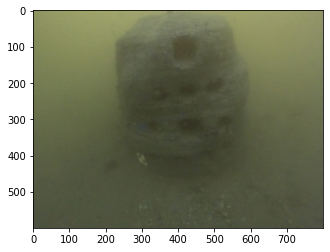

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("/content/drive/MyDrive/BolsaInvestigacao/dataset_recifes/test/G0041984.JPG")
# Resize image
img = cv2.resize(img, (int(img.shape[1]/5), (int(img.shape[0]/5))))
print(img.shape)
plt.imshow(img)

## UWCNN++ Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, SpatialDropout2D, ReLU, Input, Concatenate, Add
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
def combloss (y_actual, y_predicted):
    '''
    This is the custom loss function for keras model
    :param y_actual:
    :param y_predicted:
    :return:
    '''
    # this is just l2 + lssim
    lssim = tf.constant(1, dtype=tf.float32) - tf.reduce_mean(tf.image.ssim(y_actual, y_predicted, max_val=1, filter_size=13)) #remove max_val=1.0
    lmse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)(y_actual, y_predicted)
    lmse = tf.math.multiply(lmse, 4)
    return tf.math.add(lmse, lssim)

class UWCNN(tf.keras.Model):

    def __init__(self,name=None):
        super(UWCNN, self).__init__()
        self.conv1 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze1")
        self.relu1 = ReLU()
        self.conv2 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze2")
        self.relu2 = ReLU()
        self.conv3 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze3")
        self.relu3 = ReLU()
        self.concat1 = Concatenate(axis=3)

        self.conv4 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze4")
        self.relu4 = ReLU()
        self.conv5 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze5")
        self.relu5 = ReLU()
        self.conv6 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze6")
        self.relu6 = ReLU()
        self.concat2 = Concatenate(axis=3)

        self.conv7 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze7")
        self.relu7 = ReLU()
        self.conv8 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze8")
        self.relu8 = ReLU()
        self.conv9 = Conv2D(16, 3, (1, 1), 'same', name="conv2d_dehaze9")
        self.relu9 = ReLU()
        self.concat3 = Concatenate(axis=3)

        self.conv10 = Conv2D(3, 3, (1, 1), 'same', name="conv2d_dehaze10")
        self.add1 = Add()

    def call(self, inputs):
        image_conv1 = self.relu1(self.conv1(inputs))
        image_conv2 = self.relu2(self.conv2(image_conv1))
        image_conv3 = self.relu3(self.conv3(image_conv2))
        dehaze_concat1 = self.concat1([image_conv1, image_conv2, image_conv3, inputs])

        image_conv4 = self.relu4(self.conv4(dehaze_concat1))
        image_conv5 = self.relu5(self.conv5(image_conv4))
        image_conv6 = self.relu6(self.conv6(image_conv5))
        dehaze_concat2 = self.concat2([dehaze_concat1, image_conv4, image_conv5, image_conv6])

        image_conv7 = self.relu7(self.conv7(dehaze_concat2))
        image_conv8 = self.relu8(self.conv8(image_conv7))
        image_conv9 = self.relu9(self.conv9(image_conv8))
        dehaze_concat3 = self.concat3([dehaze_concat2, image_conv7, image_conv8, image_conv9])

        image_conv10 = self.conv10(dehaze_concat3)
        out = self.add1([inputs, image_conv10])
        return out

def get_model():
    return UWCNN(name="UWCNN")

def parse_function(filename, label):
    filename_image_string = tf.io.read_file(filename)
    label_image_string = tf.io.read_file(label)
    # Decode the filename_image_string
    filename_image = tf.image.decode_bmp(filename_image_string, channels=3)
    filename_image = tf.image.convert_image_dtype(filename_image, tf.float32)
    # Decode the label_image_string
    label_image = tf.image.decode_bmp(label_image_string, channels=3)
    label_image = tf.image.convert_image_dtype(label_image, tf.float32)
    return filename_image, label_image

def combloss (y_actual, y_predicted):
    '''
    This is the custom loss function for keras model
    :param y_actual:
    :param y_predicted:
    :return:
    '''
    # this is just l2 + lssim
    lssim = tf.constant(1, dtype=tf.float32) - tf.reduce_mean(tf.image.ssim(y_actual, y_predicted, max_val=1, filter_size=13)) #remove max_val=1.0
    lmse = MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)(y_actual, y_predicted)
    lmse = tf.math.multiply(lmse, 4)
    return tf.math.add(lmse, lssim)

In [ ]:
model = UWCNN()
input_shape=(16,) + img.shape
model.build(input_shape)
model.summary()
model.load_weights('/content/UWCNN/UWCNN++/train_type1/cp.ckpt')

In [ ]:
import glob
imgs = sorted(glob.glob("/content/drive/MyDrive/BolsaInvestigacao/dataset_recifes/test/*"))

In [ ]:
import os
for img in imgs:

  filename_image_string = tf.io.read_file(img)
  filename_image = tf.image.decode_png(filename_image_string, channels=3)
  filename_image = tf.image.convert_image_dtype(filename_image, tf.float32)
  filename_image = tf.image.resize(filename_image, (460, 620))
  #filename_image = tf.image.resize(filename_image, (600, 800))
  filename_image = tf.reshape(filename_image, [1, 460, 620, 3])
  output = model.predict(filename_image)
  output = output.reshape((460, 620, 3)) * 255
  output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
  cv2.imwrite("/content/output/"+"out_"+ os.path.basename(img), output)

1/1 [==============================] - 1s 1s/step


## Results Visualization

In [ ]:
imgs_out = sorted(glob.glob("/content/output/*"))

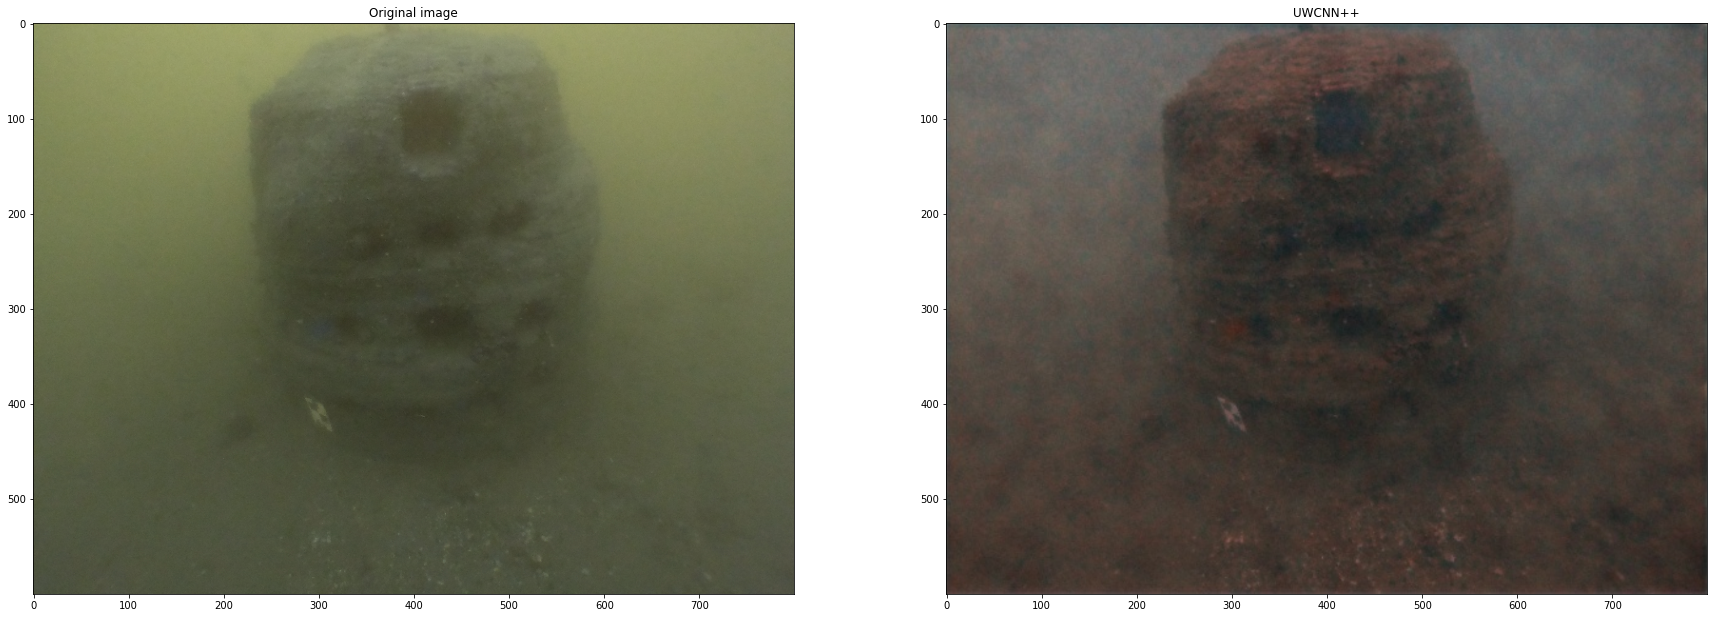

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 30))
im = cv2.imread(imgs[0])
im = cv2.resize(im, (800, 600))

ax[0].imshow(im)
ax[0].set_title("Original image")

out_img = cv2.imread(imgs_out[0])
out_img = cv2.resize(out_img, (800, 600))

ax[1].imshow(out_img)
ax[1].set_title("UWCNN++")

plt.show()

### Edges Visualization

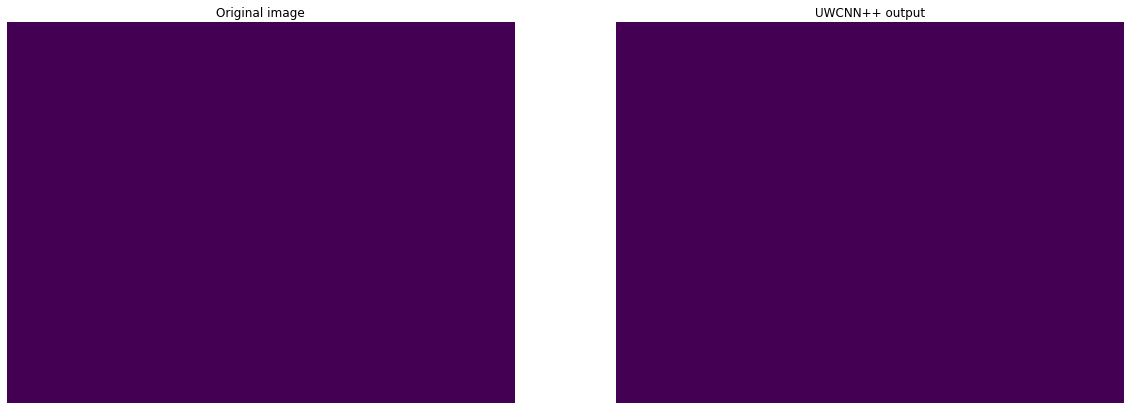

In [ ]:
edg_out = cv2.Canny(out_img,100,200)
edg_in = cv2.Canny(im,100,200)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(edg_in)
ax[0].axis("off")
ax[0].set_title("Original image")

ax[1].imshow(edg_out)
ax[1].axis("off")
ax[1].set_title("UWCNN++ output")

plt.show()

## Evalution Metrics Functions

In [ ]:
# source: https://github.com/Riccellisp/ProjetoPecem/blob/ba8c5e7b991e93044e3c86c42e48d3df4c9595fb/metrics.py

from skimage.metrics import structural_similarity as ssim
from skimage import color,filters
import numpy as np
import math
import sys

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)

    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]

            block = ch[xlb:xrb,ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)

            m = top/bottom
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

def eme(img,rowSample,columnSample):

	grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	rowSize, columnSize = grayImg.shape
	nRows = int(rowSize/rowSample)
	nColumns = int(columnSize/columnSample)
	incompleteRow = math.ceil(rowSize/rowSample) - nRows
	incompleteColumn = math.ceil(columnSize/columnSample) - nColumns

	somatory = 0
	nBlocks = nRows*nColumns
	for i in range(0,nRows):
		for j in range(0,nColumns):
			imax=grayImg[i*rowSample:(i+1)*rowSample,j*columnSample:(j+1)*rowSample].max()
			imin=grayImg[i*rowSample:(i+1)*rowSample,j*columnSample:(j+1)*rowSample].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)

	if incompleteColumn==1:
		for i in range(0,nRows):
			imax=grayImg[i*rowSample:(i+1)*rowSample,nColumns*columnSample:columnSize].max()
			imin=grayImg[i*rowSample:(i+1)*rowSample,nColumns*columnSample:columnSize].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)
			nBlocks = nBlocks + 1
	if incompleteRow==1:
		for j in range(0,nColumns):
			imax=grayImg[grayImg[nRows*rowSample:rowSize,j*columnSample:(j+1)*columnSample]].max()
			imin=grayImg[grayImg[nRows*rowSample:rowSize,j*columnSample:(j+1)*columnSample]].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)
			nBlocks = nBlocks + 1
	if incompleteRow==1 and incompleteColumn==1:
		imax=grayImg[nRows*rowSample:rowSize,nColumns*columnSample:columnSize].max()
		imin=grayImg[nRows*rowSample:rowSize,nColumns*columnSample:columnSize].max()
		if imin==0:
			imin=1
		if imax==0:
			imax=1
		somatory = somatory + 20*math.log(imax/imin)
		nBlocks = nBlocks + 1
	return somatory/nBlocks

def UCIQE(a,c1=0.4680,c2 = 0.2745,c3 = 0.2576):
    """
    Underwater colour image quality evaluation metric (UCIQE) é uma métrica baseada na combinação
    linear de croma (pureza), saturação e contraste principalmente de imagens subaquáticas, mas também
    baseadaem trabalhos atuais de avaliação de imagens coloridas atmosféricas.
    REF: M. Yang and A. Sowmya, "An Underwater Color Image Quality Evaluation Metric," in IEEE Transactions on Image Processing,
    vol. 24, no. 12, pp. 6062-6071, Dec. 2015, doi: 10.1109/TIP.2015.2491020.
    :param a: imagem de entrada
    :c1,c2,c3: coeficentes ponderados
    :return c1 * sc + c2 * conl + c3 * us
    """
    rgb = a
    lab = color.rgb2lab(a)
    l = lab[:,:,0]

    #1st term
    chroma = (lab[:,:,1]**2 + lab[:,:,2]**2)**0.5
    uc = np.mean(chroma)
    sc = (np.mean((chroma - uc)**2))**0.5

    #2nd term
    top = int(np.round(0.01*l.shape[0]*l.shape[1]))
    sl = np.sort(l,axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[:top])-np.mean(sl[:top])

    #3rd term
    satur = []
    chroma1 = chroma.flatten()
    l1 = l.flatten()
    for i in range(len(l1)):
      if chroma1[i] == 0: satur.append(0)
      elif l1[i] == 0: satur.append(0)
      else: satur.append(chroma1[i] / l1[i])

    us = np.mean(satur)

    return  c1 * sc + c2 * conl + c3 * us

def UIQM(a,p1=0.0282,p2=0.2953,p3=3.5753):
    """
    REF: K. Panetta, C. Gao and S. Agaian, Human-Visual-System-Inspired Underwater Image Quality Measures,
    in IEEE Journal of Oceanic Engineering, vol. 41, no. 3, pp. 541-551, July 2016, doi: 10.1109/JOE.2015.2469915.
    Metrica sem referencia, semelhante a UCIQE, mas mais atual. Leva em consideração a medida de colorção,
    medida de nitidez e medida de contraste.
    """
    #1st term UICM
    #TαL=⌈αLK⌉ - > o inteiro mais próximo maior ou igual a αLK
    #TαR=⌊αRK⌋ - > o inteiro mais próximo menor ou igual a αRK
    rgb=a
    gray = color.rgb2gray(a)
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr) # μ^2_α,RG
    s2rg = np.mean((rgl_tr - urg) ** 2)  # σ2α,RG
    uyb = np.mean(ybl_tr) # μ^2_α,YB
    s2yb = np.mean((ybl_tr- uyb) ** 2) # σ2α,YB

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    #2nd term UISM (k1k2=8x8)   # medida de nitidez de imagem
    """Para medir a nitidez nas bordas, o detector de bordas Sobel é aplicado primeiro em cada componente de cor RGB
      O mapa de arestas resultante é então multiplicado pela imagem original para obter o mapa de arestas em tons de cinza."""
    # Rsobel = rgb[:,:,0] * filters.sobel(rgb[:,:,0])
    # Gsobel = rgb[:,:,1] * filters.sobel(rgb[:,:,1])
    # Bsobel = rgb[:,:,2] * filters.sobel(rgb[:,:,2])

    # Rsobel=np.round(Rsobel).astype(np.uint8)  # Arredonda a matriz para numeros inteiros
    # Gsobel=np.round(Gsobel).astype(np.uint8)
    # Bsobel=np.round(Bsobel).astype(np.uint8)

    Reme = eme(a,8,8)
    Geme = eme(a,8,8)
    Beme = eme(a,8,8)
    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    #3rd term UIConM
    uiconm = logamee(gray)
    uiqm = p1 * uicm + p2 * uism + p3 * uiconm

    return uiqm

def CCF(imageRGB):
	"""REF:
	@article{WANG2018904,
	title = {An imaging-inspired no-reference underwater color image quality assessment metric},
	journal = {Computers & Electrical Engineering},
	volume = {70},
	pages = {904-913},
	year = {2018},
	issn = {0045-7906},
	doi = {https://doi.org/10.1016/j.compeleceng.2017.12.006},
	url = {https://www.sciencedirect.com/science/article/pii/S0045790617324953},
	author = {Yan Wang and Na Li and Zongying Li and Zhaorui Gu and Haiyong Zheng and Bing Zheng and Mengnan Sun},
	keywords = {No-reference image quality assessment, Underwater imaging, Underwater image, Underwater color image quality},
	abstract = {Underwater color image quality assessment (IQA) plays an important role in analysis and applications of underwater imaging as well as image processing algorithms. This paper presents a new metric inspired by the imaging analysis on underwater absorption and scattering characteristics, dubbed the CCF. This metric is feature-weighted with a combination of colorfulness index, contrast index and fog density index, which can quantify the color loss caused by absorption, the blurring caused by forward scattering and the foggy caused by backward scattering, respectively. Then multiple linear regression is used to calculate three weighted coefficients. A new underwater image database is built to illustrate the performance of the proposed metric. Experimental results show a strong correlation between the proposed metric and mean opinion score (MOS). The proposed CCF metric outperforms many of the leading atmospheric IQA metrics, and it can effectively assess the performance of underwater image enhancement and image restoration methods.}
	}

	Métrica sem referência. Essa métrica é ponderada por recursos com uma combinação de índice de colorido,
	índice de contraste e índice de densidade de neblina, que pode quantificar a perda de cor
	causada pela absorção, o desfoque causado pela dispersão para frente e o nevoeiro causado
	pela dispersão para trás, respectivamente.
	"""
  # Rij=np.log(rgb[:,:,0])-np.mean(rgb[:,:,0], out=np.zeros_like(rgb[:,:,0])-np.mean(rgb[:,:,0]), where=(rgb[:,:,0])-np.mean(rgb[:,:,0]!=0))
	# Gij=np.log(rgb[:,:,1])-np.mean(rgb[:,:,1], out=np.zeros_like(rgb[:,:,1])-np.mean(rgb[:,:,1]), where=(rgb[:,:,1])-np.mean(rgb[:,:,1]!=0))
	# Bij=np.log(rgb[:,:,2])-np.mean(rgb[:,:,2], out=np.zeros_like(rgb[:,:,2])-np.mean(rgb[:,:,2]), where=(rgb[:,:,2])-np.mean(rgb[:,:,2]!=0))
	rgb=imageRGB
	gray = color.rgb2gray(imageRGB)
	# Passo 1
	Rij=np.log(rgb[:,:,0])-np.mean(rgb[:,:,0])
	Gij=np.log(rgb[:,:,1])-np.mean(rgb[:,:,1])
	Bij=np.log(rgb[:,:,2])-np.mean(rgb[:,:,2])

	# Passo 2
	a = rgb[:,:,0] - rgb[:,:,1]
	b = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]

	var_a  = np.var(a)
	var_b  = np.var(b)
	mean_a = np.mean(a)
	mean_b = np.mean(b)

	ccf=(math.sqrt(var_a+var_b)+0.3*math.sqrt(var_a+var_b)) /85.59


	return ccf

In [ ]:
UIQM_list, UCIQE_list, CCF_list  = list(), list(), list()
UIQM_out_list, UCIQE_out_list, CCF_out_list  = list(), list(), list()
for img in imgs:
  im = cv2.imread(img)
  im = cv2.resize(im, (800, 600))
  UIQM_list.append(UIQM(im))
  UCIQE_list.append(UCIQE(im))
  CCF_list.append(CCF(im))

for img in imgs_out:
  im = cv2.imread(img)
  im = cv2.resize(im, (800, 600))
  UIQM_out_list.append(UIQM(im))
  UCIQE_out_list.append(UCIQE(im))
  CCF_out_list.append(CCF(im))

In [ ]:
np.mean(UIQM_list), np.std(UIQM_list)

(0.7511057229103216, 0.6609179233059735)

In [ ]:
np.mean(UCIQE_list), np.std(UCIQE_list)

(18.056804946491035, 3.3883908529062317)

In [ ]:
np.mean(CCF_list), np.std(CCF_list)

(1.1041827219337752, 0.5398153030639654)

In [ ]:
np.mean(UIQM_out_list), np.std(UIQM_out_list)

(1.1860692221084033, 0.8908690483743276)

In [ ]:
np.mean(UCIQE_out_list), np.std(UCIQE_out_list)

(14.262499298315042, 2.9243948542571507)

In [ ]:
np.mean(CCF_out_list), np.std(CCF_out_list)

(0.7787980804844731, 0.5804337891875515)

In [ ]:
!zip -r /content/output_UWCNN.zip /content/output